## Проект: Прогнозирование оттока клиентов

### Описание проекта
Необходимо производить прогноз отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

Основная метрика для проверки качества модели: roc_auc
Дополнительная метрика: accuracy

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### План выполнения работы

**1. Исследовательский анализ данных**

- Данные файла: Contract
- Данные файла: Personal
- Данные файла: Internet
- Данные файла: Phone
- Объединение данных

**2. Предобработка данных.**

- Заполнение пропусков
- Сплит данных

**3. Обучение и валидация моделей**

- Dummy-модель
- Logistic Regression
- RandomForest
- LightGBM
- CatBoost

**4. Тестирование лучшеймодели**

- Оценка точности итоговой модели
- Оценка важности признаков итоговой модели

**5. Вывод**

- Общий вывод по работе

**После уточнения у тимлида стала известна следующая информация:**

**Описание полей данных:**

- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – безналичный расчет,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги
- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)
- MultipleLines – наличие возможности ведения параллельных линий во время звонка

## 1. Исследовательский анализ данных

In [738]:
#подключаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [739]:
#загружаем данные
contract = pd.read_csv('../../final_provider/contract.csv', index_col="customerID")
internet = pd.read_csv('../../final_provider/internet.csv', index_col="customerID")
personal = pd.read_csv('../../final_provider/personal.csv', index_col="customerID")
phone = pd.read_csv('../../final_provider/phone.csv', index_col="customerID")

### 1.1 Данные файла: Contract

In [740]:
contract.head(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [741]:
contract.tail(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6
3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,6844.5


In [742]:
contract.sample()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
5995-SNNEW,2018-03-01,No,Month-to-month,Yes,Electronic check,104.45,2184.85


In [743]:
contract.shape

(7043, 7)

In [744]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [745]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


1) Всего 7043 записей, 7 столбцов. Пропусков нет.

2) В столбце 'MonthlyCharges' данные слегка смещены влево (среднее меньше медианы).

3) Изменим форматы: 
- 'BeginDate', 'EndDate' -> datetime ("No" заменим на на 1 февраля 2020, на эту дату пользователи продолжали пользоваться услугами), 
- 'Type', 'PaymentMethod' -> integer по группам, 
- 'PaperlessBilling' -> integer (бинарный вид), 
- 'TotalCharges' -> float.

In [746]:
last_date = '2020-02-01'

contract.loc[contract['EndDate']=='No', 'EndDate'] = last_date
len(contract.loc[contract['EndDate']=='No', 'EndDate'])

0

In [747]:
contract['EndDate'] = contract['EndDate'].astype('datetime64')
contract['BeginDate'] = contract['BeginDate'].astype('datetime64')

In [748]:
contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [749]:
#напишем функцию перевода категорий в целые числа
def type_func(my_type):
    if my_type == "Month-to-month":
        int_type = 0
    elif my_type == "One year": 
        int_type = 1
    elif my_type == "Two year":
        int_type = 2
    else:
        int_type = 3
        
    return int_type

In [750]:
contract['Type'] = contract['Type'].apply(type_func).astype('int')

In [751]:
contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [752]:
#напишем функцию перевода категорий в целые числа
def payment_func(my_payment):
    if my_payment == "Electronic check":
        int_type = 0
    elif my_payment == "Mailed check": 
        int_type = 1
    elif my_payment == "Bank transfer (automatic)":
        int_type = 2
    elif my_payment == "Credit card (automatic)":
        int_type = 3
    else:
        int_type = 4
        
    return int_type

In [753]:
contract['PaymentMethod'] = contract['PaymentMethod'].apply(payment_func).astype('int')

In [754]:
contract['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [755]:
#напишем функцию перевода категорий в целые числа
def billing_func(my_billing):
    if my_billing == "No":
        int_type = 0
    elif my_billing == "Yes": 
        int_type = 1
    else:
        int_type = 2
        
    return int_type

In [756]:
contract['PaperlessBilling'] = contract['PaperlessBilling'].apply(billing_func).astype('int')

contract['TotalCharges'] = contract['TotalCharges'].astype('float') -> вызывает ошибку, есть строковое представление ' '.

In [757]:
contract[contract['TotalCharges']==' ']

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,2,1,2,52.55,
3115-CZMZD,2020-02-01,2020-02-01,2,0,1,20.25,
5709-LVOEQ,2020-02-01,2020-02-01,2,0,1,80.85,
4367-NUYAO,2020-02-01,2020-02-01,2,0,1,25.75,
1371-DWPAZ,2020-02-01,2020-02-01,2,0,3,56.05,
7644-OMVMY,2020-02-01,2020-02-01,2,0,1,19.85,
3213-VVOLG,2020-02-01,2020-02-01,2,0,1,25.35,
2520-SGTTA,2020-02-01,2020-02-01,2,0,1,20.00,
2923-ARZLG,2020-02-01,2020-02-01,1,1,1,19.70,


In [758]:
len(contract[contract['TotalCharges']==' '])

11

11 пустот в столбце TotalCharges, возможно связано с тем, что пользователи не успели заплатить. Дата BeginDate совпадает с EndDate, MonthlyCharges != 0. **Логичным заполнением пропуска в данном случае будет - нулями (пока что заменим на NaN чтобы не изменять распределение параметров в ходе исследовательского анализа данных).**

In [759]:
contract.loc[contract['TotalCharges']==' ', 'TotalCharges'] = 'NaN'

In [760]:
len(contract[contract['TotalCharges']==' '])

0

In [761]:
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

In [762]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   int32         
 3   PaperlessBilling  7043 non-null   int32         
 4   PaymentMethod     7043 non-null   int32         
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int32(3)
memory usage: 357.7+ KB


- Ключевой признак - уход клиента. Клиент ушел, если EndDate < 2020-02-01. 
- Вместо BeginDate и EndDate создадим 2 признака: (1) сколько дней человек пробыл клиентом компании, (2) ушел ли в итоге клиент.

In [763]:
contract['days_count'] = (contract['EndDate'] - contract['BeginDate']) // np.timedelta64(1, 'D')
contract['days_count'] = contract['days_count'].astype('float')

In [764]:
contract['days_count'].head(5)

customerID
7590-VHVEG      31.0
5575-GNVDE    1036.0
3668-QPYBK      61.0
7795-CFOCW    1371.0
9237-HQITU      61.0
Name: days_count, dtype: float64

In [765]:
contract['exited'] = ((pd.Timestamp(last_date) - contract['EndDate']) // np.timedelta64(1, 'D') > 0).astype('int')

In [766]:
contract['exited'].head(5)

customerID
7590-VHVEG    0
5575-GNVDE    0
3668-QPYBK    1
7795-CFOCW    0
9237-HQITU    1
Name: exited, dtype: int32

In [767]:
contract = contract.drop(['BeginDate', 'EndDate'], axis=1)

Можно проанализировать данные

In [768]:
contract.head(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days_count,exited
customerID,,,,,,,
7590-VHVEG,0,1,0,29.85,29.85,31.0,0
5575-GNVDE,1,0,1,56.95,1889.50,1036.0,0
3668-QPYBK,0,1,1,53.85,108.15,61.0,1
7795-CFOCW,1,0,2,42.30,1840.75,1371.0,0
9237-HQITU,0,1,0,70.70,151.65,61.0,1


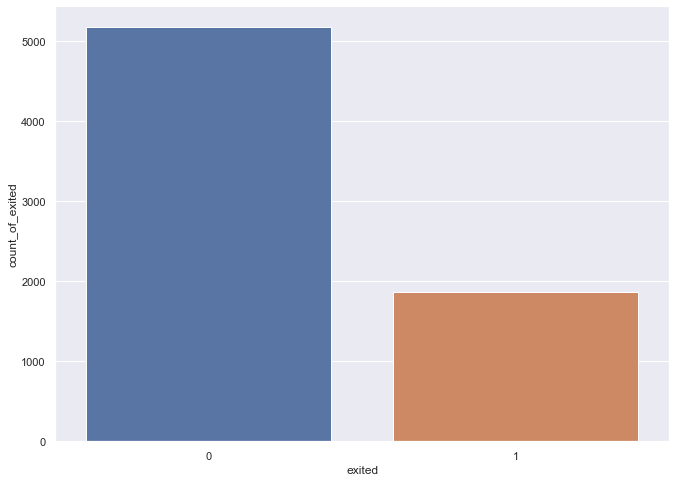

In [769]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale = 1)
barplot = sns.barplot(x=contract['exited'].value_counts().index, y=contract['exited'].value_counts().values);
barplot.set(xlabel='exited', ylabel='count_of_exited')
plt.show()

Виден дисбаланс в классах, при разделении данных будем использовать стратифицированный сплит

In [770]:
#напишем функцию построения distplot
def compare_clients(comparer_ex, comparer, comparer_name_ex, comparer_name, bins):
    
    ab = sns.set(rc={'figure.figsize':(8,8)}, font_scale=1)
    f, axes = plt.subplots(1, 1)
    sns.distplot(comparer_ex, label=comparer_name_ex, bins=bins)
    sns.distplot(comparer, label=comparer_name, bins=bins)
    
    axes.set(title=('Плотность распределения по столбцу: ' + comparer_ex.name),
             xlabel='Значение параметра',
             ylabel=('Плотность распределения параметра'))
    plt.legend(fontsize=16)
    plt.show()

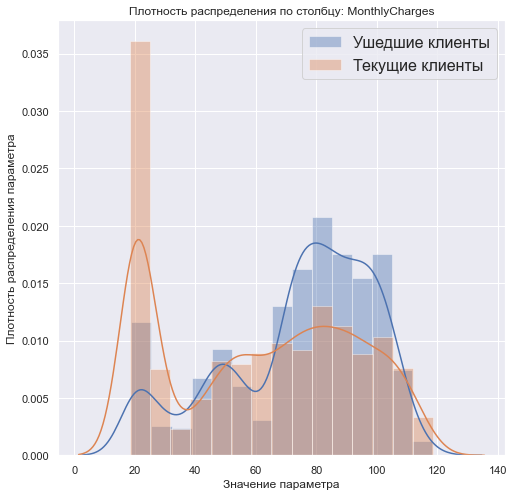

In [771]:
compare_clients(contract[contract['exited']==1]['MonthlyCharges'],
                contract[contract['exited']==0]['MonthlyCharges'],
                'Ушедшие клиенты',
                'Текущие клиенты',
                15)

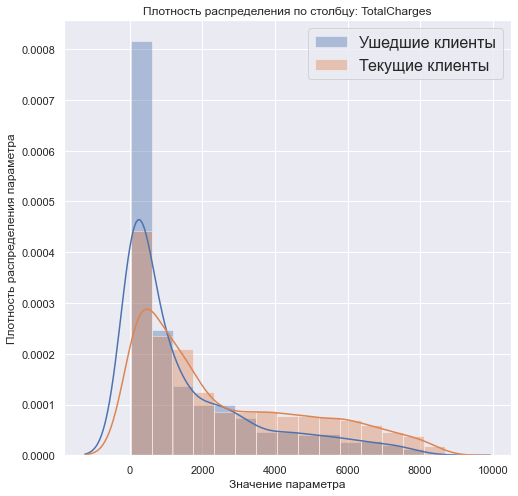

In [772]:
compare_clients(contract[contract['exited']==1]['TotalCharges'],
                contract[contract['exited']==0]['TotalCharges'],
                'Ушедшие клиенты',
                'Текущие клиенты',
                15)

Из графиков распределения численных параметров видно:

1. Значения столбца помесячной оплаты MonthlyCharges больше для ушедших клиентов. Возможно, это и было причиной их ухода. 
2. Значения столбца общей платы TotalCharges больше для текущих клиентов. Логично, что в долгосрочной перспективе профит от постоянных клиентов больше. 

In [773]:
#напишем функцию построения countplot
def count_ploter(data, column):
    
    sns.set(rc={'figure.figsize':(8,8)}, font_scale=1)
    countplot = sns.countplot(x=column, hue='exited', data=data)
    countplot.set(title=('Countplot для параметра ' + column), ylabel='Количество значений')
    
    plt.show()

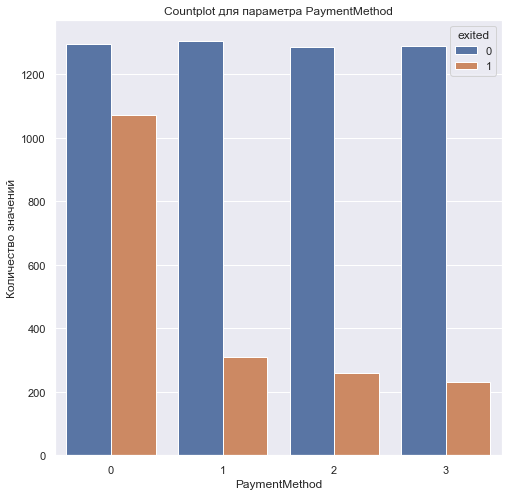

In [774]:
count_ploter(contract, 'PaymentMethod')

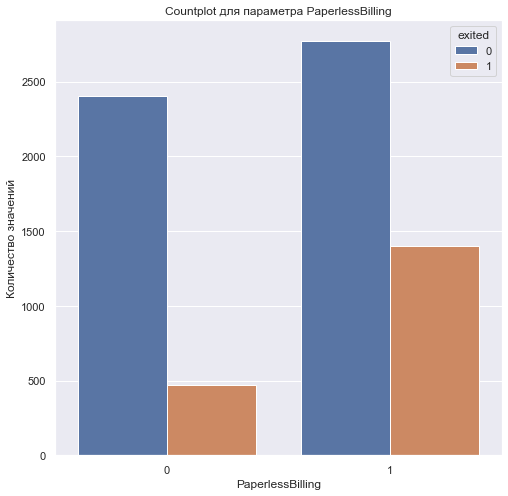

In [775]:
count_ploter(contract, 'PaperlessBilling')

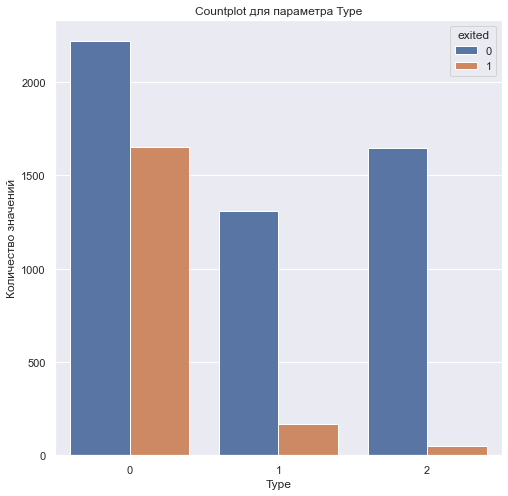

In [776]:
count_ploter(contract, 'Type')

**Из столбчатых диаграмм выше делаем следующие выводы:**

Ушедшие клиенты в основном выделяются по следующим группам:
1. Тип оплаты Type = Month-to-Month, то есть помесячная оплата.
2. Способ оплаты PaymentMethod = Electronic Check (по столбцу PaperlessBilling больше ушедших клиентов пользовалось безналичной оплатой, но текущих клиентов также больше в группе безналичной оплаты). 

*Интересно посмотреть на зависимость столбцов по другим файлам со столбцом exited в файле contract. Для этого проработаем остальные csv файлы и объединим их в единую таблицу.*

### 1.2 Данные файла: Personal

In [777]:
personal.head(5)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [778]:
personal.tail(5)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
6840-RESVB,Male,0,Yes,Yes
2234-XADUH,Female,0,Yes,Yes
4801-JZAZL,Female,0,Yes,Yes
8361-LTMKD,Male,1,Yes,No
3186-AJIEK,Male,0,No,No


In [779]:
personal.sample()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
0940-OUQEC,Male,0,No,No


In [780]:
personal.shape

(7043, 4)

In [781]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


Переведем все object форматы в целочисленный int32:

In [782]:
def yes_no_to_int32(data, columns):
    
    for column in columns:
        data[column] = (data[column] == 'Yes').astype('int32')

In [783]:
personal_list_to_func = list(personal.columns)
personal_list_to_func.remove('gender')
personal_list_to_func.remove('SeniorCitizen')
yes_no_to_int32(personal, personal_list_to_func)

In [784]:
personal['gender'] = (personal['gender'] == 'Male').astype('int32')
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('int32')

In [785]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   gender         7043 non-null   int32
 1   SeniorCitizen  7043 non-null   int32
 2   Partner        7043 non-null   int32
 3   Dependents     7043 non-null   int32
dtypes: int32(4)
memory usage: 165.1+ KB


In [786]:
personal.head(5)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,0,0,1,0
5575-GNVDE,1,0,0,0
3668-QPYBK,1,0,0,0
7795-CFOCW,1,0,0,0
9237-HQITU,0,0,0,0


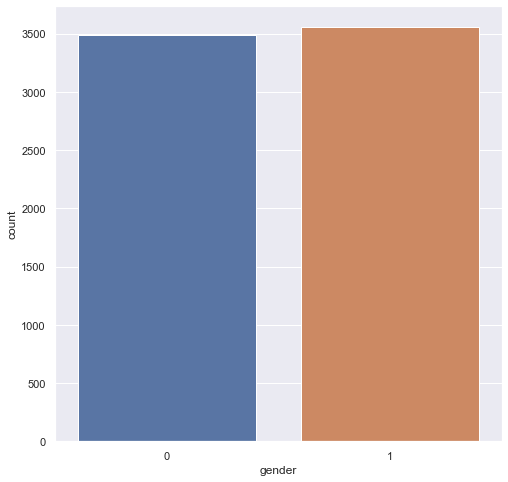

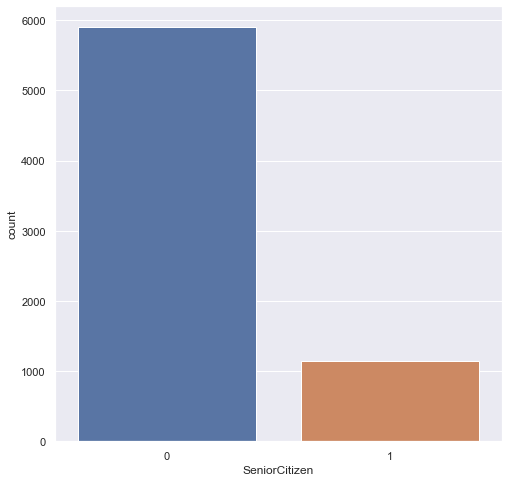

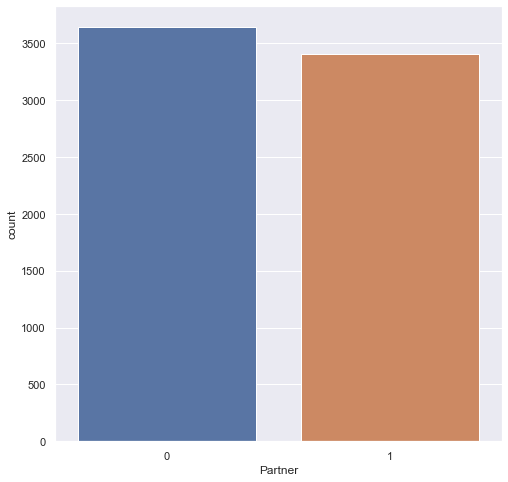

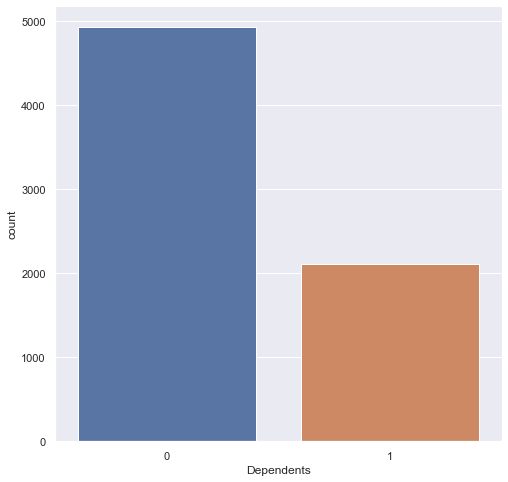

In [787]:
for column in list(personal.columns):
    sns.countplot(x=personal[column]);
    plt.show()

**По файлу personal:**

- Всего 7043 записи по 4 столбцам-категориям, пропусков нет.
- Привели все столбцы к формату int32
- Имеется дисбаланс в столбцах Dependents (наличие иждивенцев), SeniorCitizen (наличие пенсионного статуса по возрасту). Для столбцов Gender (гендер) и Partner (наличие супруга) дисбаланса не наблюдаем.

### 1.3 Данные файла: Internet

In [788]:
internet.head(5)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [789]:
internet.tail(5)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
4801-JZAZL,DSL,Yes,No,No,No,No,No
8361-LTMKD,Fiber optic,No,No,No,No,No,No
3186-AJIEK,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


In [790]:
internet.sample()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
8152-VETUR,Fiber optic,No,Yes,No,No,Yes,Yes


In [791]:
internet.shape

(5517, 7)

In [792]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [793]:
internet_list_to_func = list(internet.columns)
internet_list_to_func.remove('InternetService')

yes_no_to_int32(internet, internet_list_to_func)

In [794]:
internet['InternetService'] = (internet['InternetService'] == 'Fiber optic').astype('int32')

In [795]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   InternetService   5517 non-null   int32
 1   OnlineSecurity    5517 non-null   int32
 2   OnlineBackup      5517 non-null   int32
 3   DeviceProtection  5517 non-null   int32
 4   TechSupport       5517 non-null   int32
 5   StreamingTV       5517 non-null   int32
 6   StreamingMovies   5517 non-null   int32
dtypes: int32(7)
memory usage: 194.0+ KB


In [796]:
internet.head(5)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,0,0,1,0,0,0,0
5575-GNVDE,0,1,0,1,0,0,0
3668-QPYBK,0,1,1,0,0,0,0
7795-CFOCW,0,1,0,1,1,0,0
9237-HQITU,1,0,0,0,0,0,0


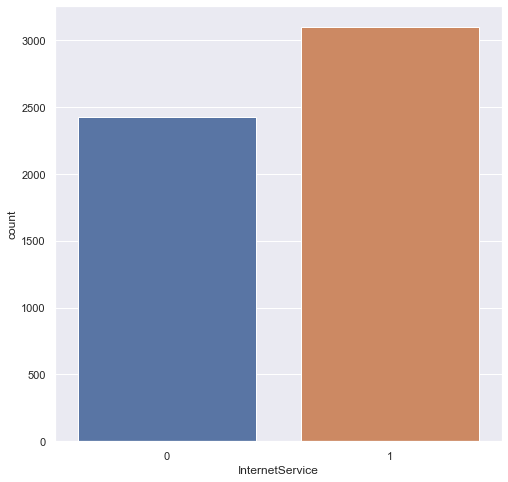

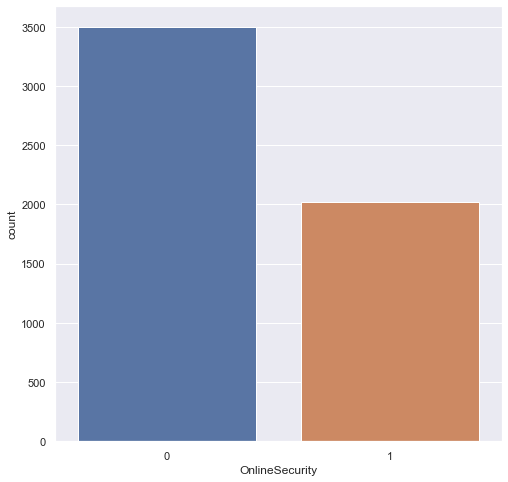

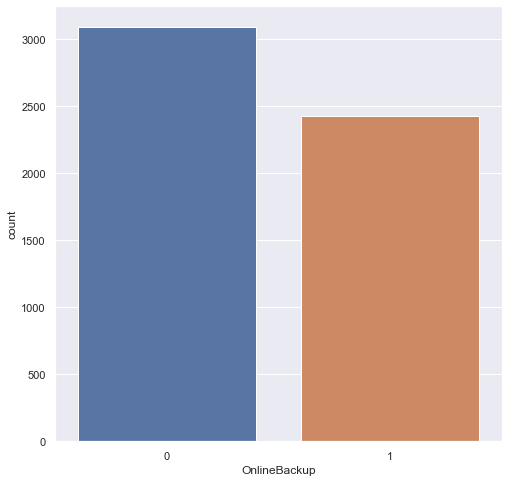

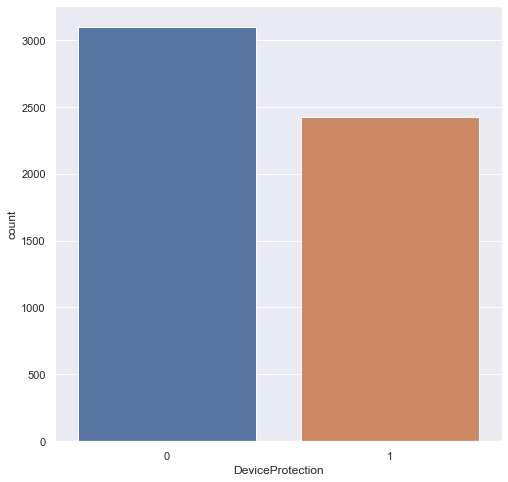

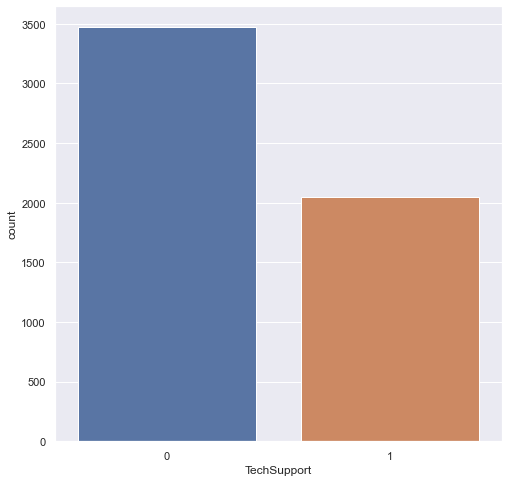

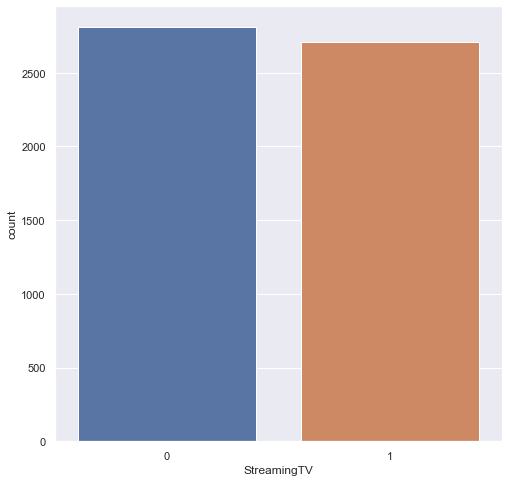

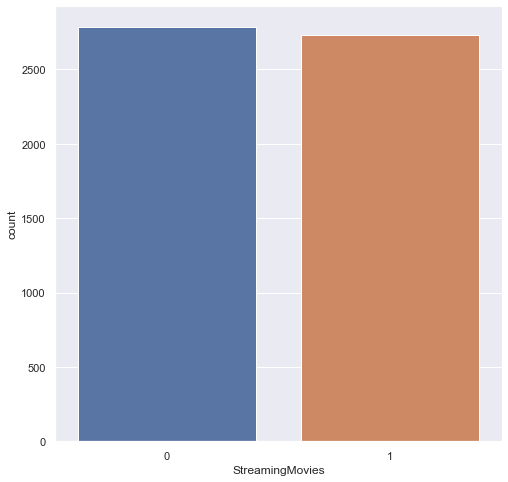

In [797]:
for column in list(internet.columns):
    sns.countplot(x=internet[column]);
    plt.show()

**По файлу internet:**

- Всего 5517 записи по 7 столбцам-категориям, пропусков нет.
- Привели все столбцы к формату int32
- Количество пользователей, использующих Fiber optic, больше чем тех, кто использует DSL
- Имеется значительный дисбаланс (примерно в 2 раза, больше тех кто не используется услугу) в столбцах OnlineSecurity, TechSupport, незначительный дисбаланс (также больше тех, кто не используется услугу) в столбцах OnlineBackup, DeviceProtection. Для столбцов StreamingTV и StreamingMovies дисбаланса не наблюдается.

### 1.4 Данные файла: Phone

In [798]:
phone.head(5)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [799]:
phone.tail(5)

,MultipleLines
customerID,
2569-WGERO,No
6840-RESVB,Yes
2234-XADUH,Yes
8361-LTMKD,Yes
3186-AJIEK,No


In [800]:
phone.sample()

,MultipleLines
customerID,
6013-BHCAW,Yes


In [801]:
phone.shape

(6361, 1)

In [802]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [803]:
yes_no_to_int32(phone, list(phone.columns))

In [804]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   MultipleLines  6361 non-null   int32
dtypes: int32(1)
memory usage: 74.5+ KB


In [805]:
phone.head(5)

,MultipleLines
customerID,
5575-GNVDE,0
3668-QPYBK,0
9237-HQITU,0
9305-CDSKC,1
1452-KIOVK,1


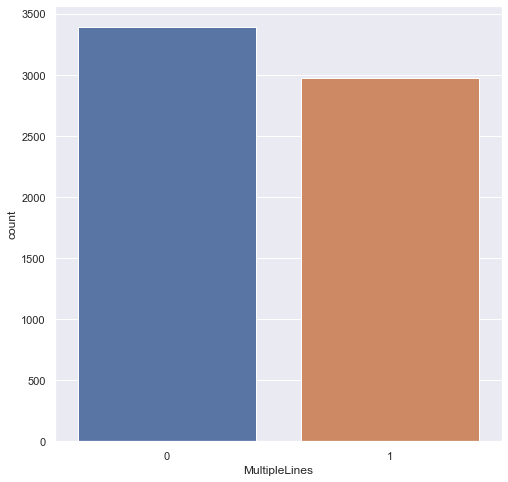

In [806]:
sns.countplot(x=phone['MultipleLines']);

**По файлу phone:**

- Всего 6361 записи по 1 столбцу-категории, пропусков нет.
- Привели все столбцы к формату int32
- Имеется незначительный дисбаланс (больше тех, кто не используется услугу) в столбце MultipleLines.

### 1.5 Объединение данных

**Объедими по индексу пользователя рассмотренные выше файлы в один с помощью метода join. Посмотрим, как распределяются данные файлов personal, internet, phone для разных значений столбца exited.**

In [807]:
df = contract.join(personal).join(internet).join(phone)

In [808]:
df.head(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days_count,exited,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,0,29.85,29.85,31.0,0,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
5575-GNVDE,1,0,1,56.95,1889.50,1036.0,0,1,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3668-QPYBK,0,1,1,53.85,108.15,61.0,1,1,0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
7795-CFOCW,1,0,2,42.30,1840.75,1371.0,0,1,0,0,0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN
9237-HQITU,0,1,0,70.70,151.65,61.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [809]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   int32  
 1   PaperlessBilling  7043 non-null   int32  
 2   PaymentMethod     7043 non-null   int32  
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   days_count        7043 non-null   float64
 6   exited            7043 non-null   int32  
 7   gender            7043 non-null   int32  
 8   SeniorCitizen     7043 non-null   int32  
 9   Partner           7043 non-null   int32  
 10  Dependents        7043 non-null   int32  
 11  InternetService   5517 non-null   float64
 12  OnlineSecurity    5517 non-null   float64
 13  OnlineBackup      5517 non-null   float64
 14  DeviceProtection  5517 non-null   float64
 15  TechSupport       5517 non-null   float64
 16  StreamingTV       5517 non-null 

Заметно большое количество пропусков, не будем их обрабатывать на этапе исследовательского анализа, чтобы сохранить исходное распределение параметров.

In [810]:
df.head(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days_count,exited,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,0,29.85,29.85,31.0,0,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
5575-GNVDE,1,0,1,56.95,1889.50,1036.0,0,1,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3668-QPYBK,0,1,1,53.85,108.15,61.0,1,1,0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
7795-CFOCW,1,0,2,42.30,1840.75,1371.0,0,1,0,0,0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN
9237-HQITU,0,1,0,70.70,151.65,61.0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [811]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   int32  
 1   PaperlessBilling  7043 non-null   int32  
 2   PaymentMethod     7043 non-null   int32  
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   days_count        7043 non-null   float64
 6   exited            7043 non-null   int32  
 7   gender            7043 non-null   int32  
 8   SeniorCitizen     7043 non-null   int32  
 9   Partner           7043 non-null   int32  
 10  Dependents        7043 non-null   int32  
 11  InternetService   5517 non-null   float64
 12  OnlineSecurity    5517 non-null   float64
 13  OnlineBackup      5517 non-null   float64
 14  DeviceProtection  5517 non-null   float64
 15  TechSupport       5517 non-null   float64
 16  StreamingTV       5517 non-null 

In [812]:
list_not_in_contract = list(personal.columns) + list(internet.columns) + list(phone.columns)

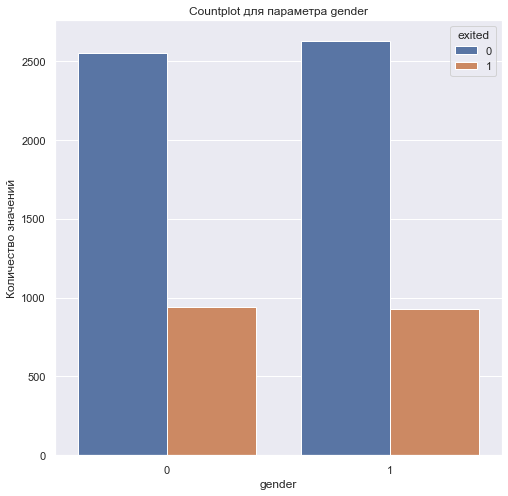

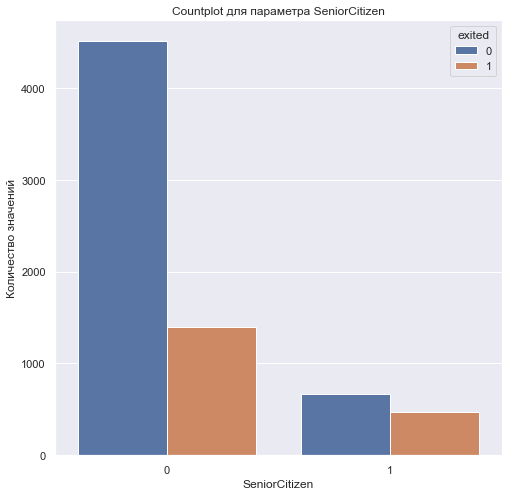

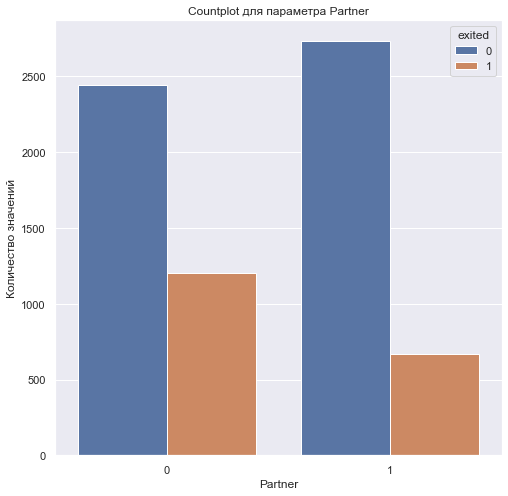

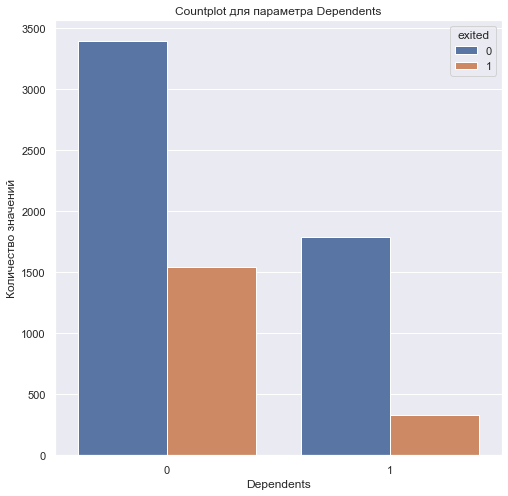

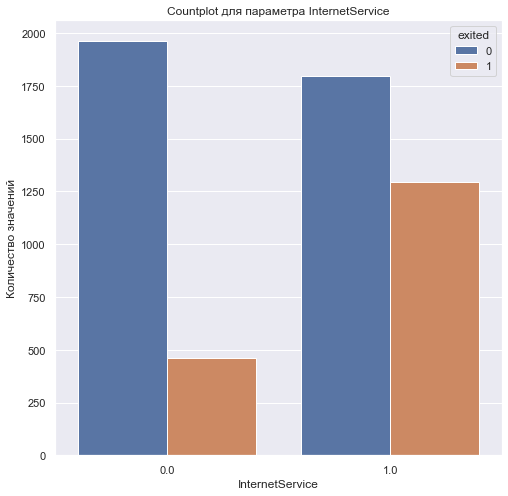

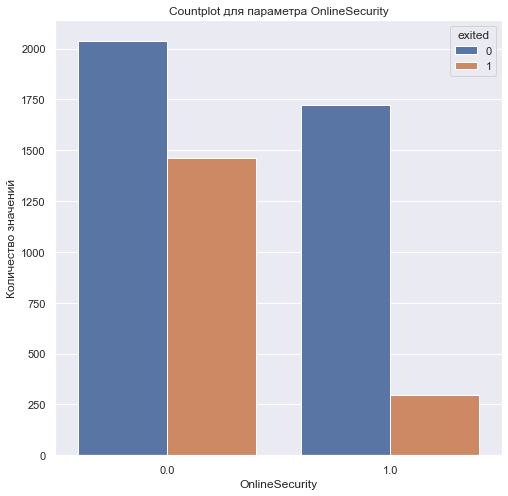

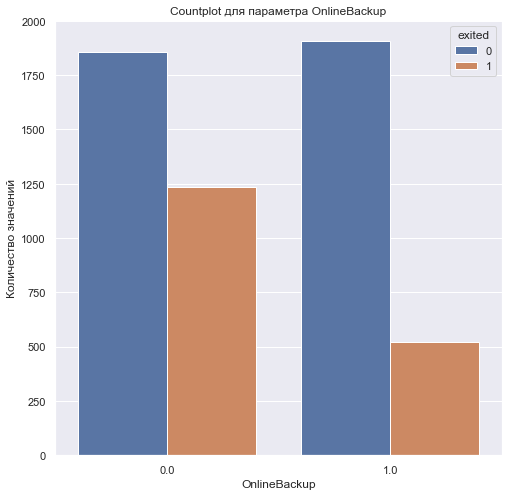

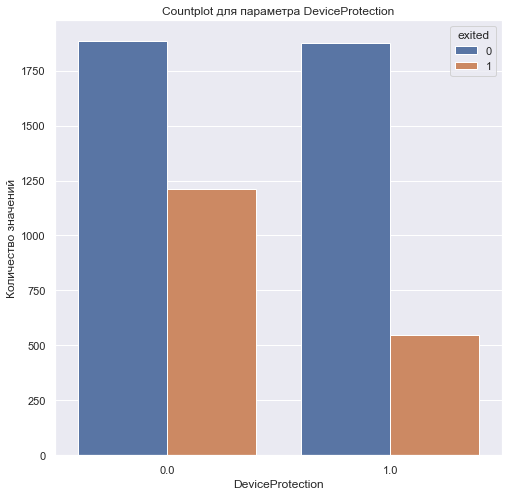

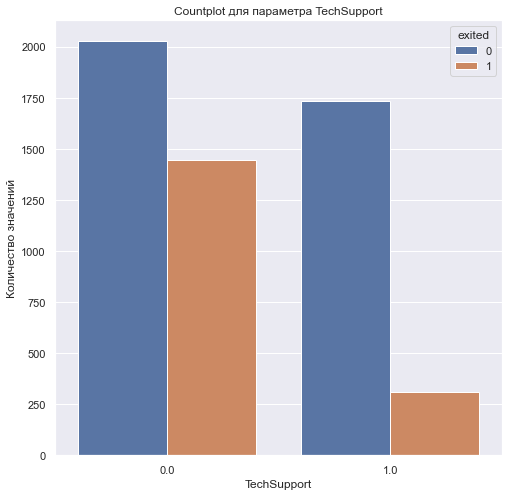

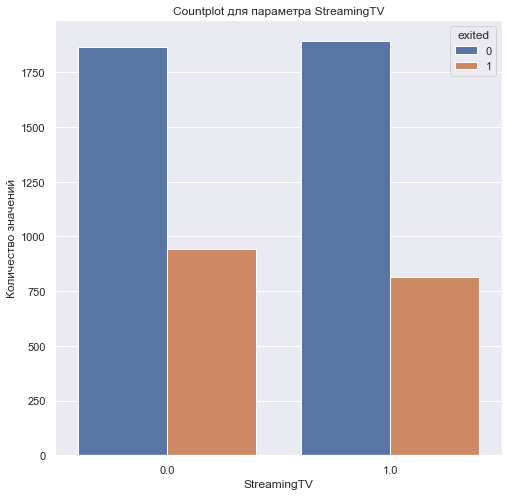

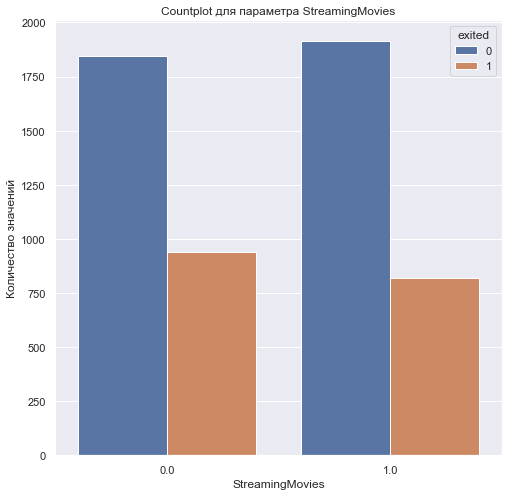

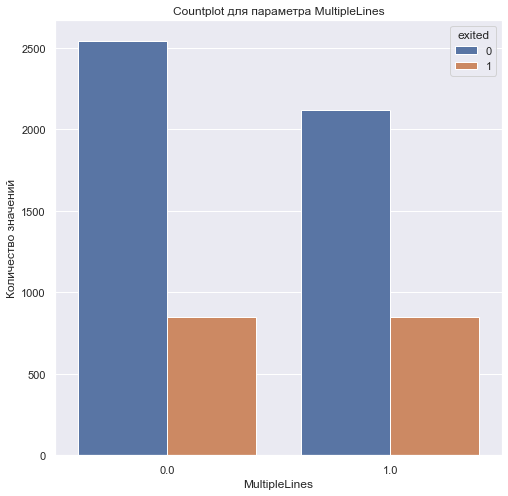

In [813]:
for column in list_not_in_contract:
    count_ploter(df, column)

По столбчатым диаграммам выше можно отметить:

1. Gender: Одинаковая динамика по категории. Почти равное количество человек мужского и женского пола для текущих клиентов. Почти равное количество человек мужского и женского пола для ушедших клиентов.
2. SeniorCitizen: В пропорции доля ушедших больше для клиентов с пенсионным статусом по возрасту (значение SeniorCitizen = 1). Но общее количество молодых клиентов значительно превышает количество пенсионеров по возрасту.
3. Partner: В пропорции доля ушедших значительно больше для категории "без супруга" (значение Partner = 0).
4. Dependents: В пропорции доля ушедших значительно больше, когда нет "иждивенцев" (значение Dependents = 0).
5. InternetService: В пропорции доля ушедших значительно больше для использующих fiber optic (значение InternetService = 1).
6. OnlineSecurity: В пропорции доля ушедших значительно больше для неиспользующих блокировку небезопасных сайтов (значение OnlineSecurity = 0).
7. OnlineBackup: В пропорции доля ушедших значительно больше для неиспользующих облачное хранилище файлов для резервного копирования данных (значение OnlineBackup = 0).
8. DeviceProtection: В пропорции доля ушедших значительно больше для неиспользующих антивирус (значение DeviceProtection = 0).
9. TechSupport: В пропорции доля ушедших значительно больше для неиспользующих выделенную линию технической поддержки (значение TechSupport = 0).
10. StreamingTV, StreamingMovies, MultipleLines: В пропорции доля ушедших незначительно отличается по категориям  неиспользующих стриминговое телевидение, каталог фильмов и возможность ведения параллельных линий во время звонка. (значение StreamingTV, StreamingMovies, MultipleLines = 0).

**Вывод:**
- **бОльшее количество ушедших приходится на категорию "без супруга" и "без наличия иждивенцев".**
- **бОльшее количество ушедших использует fiber optic, но при этом бОльшее количество ушедших не использует услуги OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport. Возможно, стоит усилить продвижение данных услуг.**

### Выводы по пункту 1 (ИАД):

- Загрузили и объединили данные. Получили датасет: 7043 записей, 19 столбцов. Есть пропуски по ряду столбцов, в будущем заменим на 0 в столбце TotalCharges, на -1 в остальных столбцах с категориями.
- Преобразовали форматы столбцов, в итоговом датасете 10 столбцов с плавающей запятой и 9 столбцов с целочисленным форматом (изменения связаны с переводами дат в количество дней, а также строковых категорий в целочисленные).
- В столбце TotalCharges иногда формируются пустоты, что связано с тем, что пользователи не успели заплатить. Дата BeginDate совпадает с EndDate, MonthlyCharges != 0. В данном случае произвели замену нулями.
- создали 2 признака: (1) сколько дней человек пробыл клиентом компании, (**2 - ключевой признак**) ушел ли в итоге клиент.
- Замечен дисбаланс в классах целевого признака exited, при разделении данных будем использовать стратифицированный сплит

**Из графиков распределения численных параметров видно:**

1. Значения столбца помесячной оплаты MonthlyCharges больше для ушедших клиентов. Возможно, это и было причиной их ухода. 
2. Значения столбца общей платы TotalCharges больше для текущих клиентов. Логично, что в долгосрочной перспективе профит от постоянных клиентов больше. 

**Ушедшие клиенты в основном характеризуются следующим образом:**
1. Тип оплаты Type = Month-to-Month, то есть помесячная оплата. Возможно, следует предлагать долгосрочные подписки.
2. Способ оплаты PaymentMethod = Electronic Check.
3. Клиенты без супруга (Partner = 0) и нет наличия иждивенцев (Dependents = 0).
4. бОльшее количество ушедших использует fiber optic, но при этом бОльшее количество ушедших не использует услуги OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport. Возможно, стоит усилить продвижение данных услуг.

## 2. Предобработка данных

### 2.1 Заполнение пропусков

In [814]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   int32  
 1   PaperlessBilling  7043 non-null   int32  
 2   PaymentMethod     7043 non-null   int32  
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   days_count        7043 non-null   float64
 6   exited            7043 non-null   int32  
 7   gender            7043 non-null   int32  
 8   SeniorCitizen     7043 non-null   int32  
 9   Partner           7043 non-null   int32  
 10  Dependents        7043 non-null   int32  
 11  InternetService   5517 non-null   float64
 12  OnlineSecurity    5517 non-null   float64
 13  OnlineBackup      5517 non-null   float64
 14  DeviceProtection  5517 non-null   float64
 15  TechSupport       5517 non-null   float64
 16  StreamingTV       5517 non-null 

11 пустот в столбце TotalCharges, возможно связано с тем, что пользователи не успели заплатить. Дата BeginDate совпадает с EndDate, MonthlyCharges != 0. **Логичным заполнением пропуска в данном случае будет - нулями.**

Для остальных столбцов-категорий (столбцы InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines) пропуски заменим на -1.

In [815]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [816]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   int32  
 1   PaperlessBilling  7043 non-null   int32  
 2   PaymentMethod     7043 non-null   int32  
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   days_count        7043 non-null   float64
 6   exited            7043 non-null   int32  
 7   gender            7043 non-null   int32  
 8   SeniorCitizen     7043 non-null   int32  
 9   Partner           7043 non-null   int32  
 10  Dependents        7043 non-null   int32  
 11  InternetService   5517 non-null   float64
 12  OnlineSecurity    5517 non-null   float64
 13  OnlineBackup      5517 non-null   float64
 14  DeviceProtection  5517 non-null   float64
 15  TechSupport       5517 non-null   float64
 16  StreamingTV       5517 non-null 

In [817]:
df = df.fillna(-1)

In [818]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   int32  
 1   PaperlessBilling  7043 non-null   int32  
 2   PaymentMethod     7043 non-null   int32  
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   days_count        7043 non-null   float64
 6   exited            7043 non-null   int32  
 7   gender            7043 non-null   int32  
 8   SeniorCitizen     7043 non-null   int32  
 9   Partner           7043 non-null   int32  
 10  Dependents        7043 non-null   int32  
 11  InternetService   7043 non-null   float64
 12  OnlineSecurity    7043 non-null   float64
 13  OnlineBackup      7043 non-null   float64
 14  DeviceProtection  7043 non-null   float64
 15  TechSupport       7043 non-null   float64
 16  StreamingTV       7043 non-null 

Переведем все категориальные признаки к целочисленному формату

In [819]:
for column in (list(internet.columns) + list(phone.columns)):
    df[column] = df[column].astype('int32')

In [820]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   int32  
 1   PaperlessBilling  7043 non-null   int32  
 2   PaymentMethod     7043 non-null   int32  
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   days_count        7043 non-null   float64
 6   exited            7043 non-null   int32  
 7   gender            7043 non-null   int32  
 8   SeniorCitizen     7043 non-null   int32  
 9   Partner           7043 non-null   int32  
 10  Dependents        7043 non-null   int32  
 11  InternetService   7043 non-null   int32  
 12  OnlineSecurity    7043 non-null   int32  
 13  OnlineBackup      7043 non-null   int32  
 14  DeviceProtection  7043 non-null   int32  
 15  TechSupport       7043 non-null   int32  
 16  StreamingTV       7043 non-null 

In [821]:
df.head(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days_count,exited,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,0,29.85,29.85,31.0,0,0,0,1,0,0,0,1,0,0,0,0,-1
5575-GNVDE,1,0,1,56.95,1889.50,1036.0,0,1,0,0,0,0,1,0,1,0,0,0,0
3668-QPYBK,0,1,1,53.85,108.15,61.0,1,1,0,0,0,0,1,1,0,0,0,0,0
7795-CFOCW,1,0,2,42.30,1840.75,1371.0,0,1,0,0,0,0,1,0,1,1,0,0,-1
9237-HQITU,0,1,0,70.70,151.65,61.0,1,0,0,0,0,1,0,0,0,0,0,0,0


### 2.2 Сплит данных

In [822]:
features = df.drop(['exited'], axis=1)
target = df['exited']

Модели будем оценивать с помощью кросс-валидации, поэтому делим датасет на обучающую (обучающая + валидационная) и тестовую выборки.

In [823]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.2,
                                                                            stratify=target,
                                                                            random_state=12345)

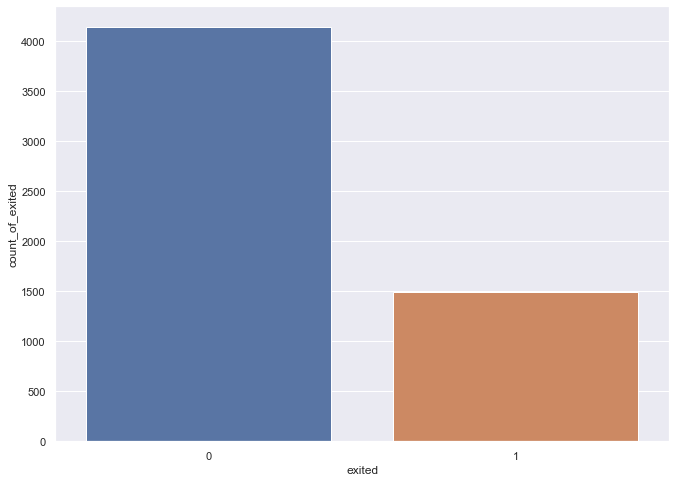

В тренировочной выборке в целевом признаке количество текущих клиентов: 4139, количество ушедших клиентов: 1495. Отношение ушедших к общему числу клиентов: 0.27


In [824]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale = 1)
barplot = sns.barplot(x=target_train.value_counts().index, y=target_train.value_counts().values);
barplot.set(xlabel='exited', ylabel='count_of_exited')
plt.show()
print(f"В тренировочной выборке в целевом признаке количество текущих клиентов: {target_train.value_counts().values[0]}, \
количество ушедших клиентов: {target_train.value_counts().values[1]}. \
Отношение ушедших к общему числу клиентов: {round(target_train.value_counts().values[1] / (target_train.value_counts().values[0] + target_train.value_counts().values[1]), 2)}\
"
)

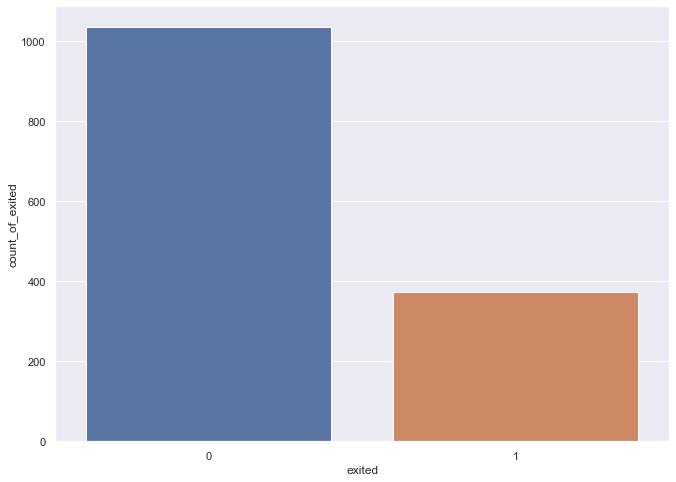

В тестовой выборке в целевом признаке количество текущих клиентов: 1035, количество ушедших клиентов: 374. Отношение ушедших к общему числу клиентов: 0.27


In [825]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale = 1)
barplot = sns.barplot(x=target_test.value_counts().index, y=target_test.value_counts().values);
barplot.set(xlabel='exited', ylabel='count_of_exited')
plt.show()

print(f"В тестовой выборке в целевом признаке количество текущих клиентов: {target_test.value_counts().values[0]}, \
количество ушедших клиентов: {target_test.value_counts().values[1]}. \
Отношение ушедших к общему числу клиентов: {round(target_test.value_counts().values[1] / (target_test.value_counts().values[0] + target_test.value_counts().values[1]), 2)}\
"
)

### Вывод по пункту 2

**Вывод по пункту 2:**

- Обработали пропуски, проверили успешность заполнения.
- Stratify-split отработал верно. Разделили данные с учетом дисбаланса. Для пункта 3, при создании класса, пропишем сплит данных с выбранным random_state.

## 3. Обучение и валидация моделей

При постановке задачи: 

Основная метрика для проверки качества модели: **roc_auc**, Дополнительная метрика: **accuracy**

In [902]:
valid_table = pd.DataFrame({'Model' : [],
                         'Params' : [],
                         'roc_auc_score' : []})
test_table = pd.DataFrame({'Model' : [],
                         'Params' : [],
                         'roc_auc_score_test' : [],
                         'accuracy_test' : []})

### 3.1 Dummy (константная модель)

Предсказание константной модели будет всегда равна группе большинства, то есть в данном случае = 0.
Для большей достоверности по точности данной модели (не требует обучения), проверим ее фунциональность на всем датасете.

In [903]:
%%time
#dummy-model

predictions = [0] * target.shape[0]
roc_auc_score_dummy = roc_auc_score(target, predictions)
accuracy_dummy = accuracy_score(target, predictions)
print(f"roc_auc_score_dummy: {round(roc_auc_score_dummy, 2)}, accuracy_dummy: {round(accuracy_dummy, 2)}")

valid_table = valid_table.append({'Model' : "dummy",
                                  'Params' : " ",
                                  'roc_auc_score' : round(roc_auc_score_dummy, 2)}, ignore_index=True)

roc_auc_score_dummy: 0.5, accuracy_dummy: 0.73
Wall time: 15 ms


- При использовании трансформаторов данных, которые обучаются на выборке, важно не допустить утечку данных. Из-за этого при кросс-валидации будет использован пайплайн, который для каждой комбинации будет обучать трансформатор (например, StandardScaler) только на текущей обучающей выборке.

- Так как для разных моделей следует по-разному подходить к представлению данных (для lightgmb, catboost используется categorical_features; для logisticregression обязателен one-hot-encoding; для древовидных моделей не обязательно использовать standardscaler и тд), напишем класс, в котором пропишем возможность гибко готовить данные и кросс-валидировать модель. 

In [904]:
class data_framework:
    '''
    Описание класса:
    Класс для подготовки данных, обучения, валидирования и тестирования моделей.
    '''
   
    def __init__(self, features, target, model_name, need_ohe, need_categories):
        '''
        Конструктор для создания образца класса:
        features - признаки
        target - ответы
        model_name - название модели
        need_ohe - необходим one-hot-encoding
        need_categories - необходимо перевести столбцы с категориями в формат category (для моделей бустинга)
        '''
        self.features = features.copy(deep = True)
        self.target = target.copy(deep = True)
        self.model_name = model_name

        self.num_features = list(features.select_dtypes(include=['float']).columns)
        self.cat_features = list(features.select_dtypes(include=['int']).columns)
        
        if need_ohe == True:
            self.ohe()
        if need_categories == True:
            self.category_format()
            
        self.data_split()
       
        self.train_test_models()
        
        #self.test_model()
        
    def data_split(self):
        '''
        Метод data_split делит исходные данные на обучающую+валидационную и тестовую выборки.
        '''
        print("Запущен сплит данных")
        self.features_train, self.features_test, self.target_train, self.target_test = train_test_split(
            self.features, self.target, test_size=0.2, random_state=12345)
        
        print("Размер обучающей+валидационной выборки: {0}, {1}".format(self.features_train.shape, self.target_train.shape))
        print("Размер тестовой выборки: {0}, {1}".format(self.features_test.shape, self.target_test.shape))
        
    def ohe(self):
        '''
        Метод ohe создает фиктивные столбцы для категорий.
        '''
        print("Запущен ohe")
        
        for column in self.cat_features:
            dummy_df = pd.get_dummies(self.features[column], drop_first=True, prefix=column)
            self.features = self.features.drop(column, axis=1)
            self.features = self.features.join(dummy_df)
            
        #print(self.features.info())
            
    def category_format(self):
        '''
        Метод category_format переводит все столбцы с категориями в категориальный формат (для моделей бустинга).
        '''
        print("Запущен category_format")
        for category in self.cat_features: 
            self.features[category] = self.features[category].astype('category')
            
        #print(self.features.info())
      
     
    def train_test_models(self):
        '''
        Метод train_valid_models обучает и валидирует модели
        '''
        print("Запущен train_test_models")
        
        global valid_table
        #определяем название модели и сетку параметров
        if (self.model_name == 'lr'):
            self.model = LogisticRegression()
            self.grid = {'model__C' : range(1,12,5)}
        elif (self.model_name == 'rf'):
            self.model = RandomForestClassifier(random_state=12345)
            self.grid = {'model__n_estimators' : range(100,500,350), 'model__max_depth': range (3,10, 5)}
        elif (self.model_name == 'lgbm'):
            self.model = LGBMClassifier(random_state=12345)
            self.grid = {'model__n_estimators' : range(100,1500,1000), 'model__max_depth': range (3,10, 5)}
        elif (self.model_name == 'catboost'):
            self.model = CatBoostClassifier(random_state=12345, verbose=500, eval_metric='AUC')
            self.grid = {'model__n_estimators' : range(100,1500,1000), 'model__max_depth': range (3,10, 5)}
        
        #прописываем трансформеры
        #self.num_transformers = StandardScaler()
        self.num_transformers = Pipeline(steps=[("scaler", StandardScaler())])
        #self.cat_transformers = Pipeline(steps=[("ohe", OneHotEncoder())])
        
        #прописываем препроцессор
        self.preprocessor = ColumnTransformer(
            transformers=[
            ("num", self.num_transformers, self.num_features)#,
            #("cat", self.cat_transformers, self.cat_features)
            ])
        #прописываем пайплайн для модели
        self.clf = Pipeline(steps=[("preprocessor", self.preprocessor), ("model", self.model)])
        #помещаем пайплайн в GridSearchCV
        kfold = KFold(n_splits=3, random_state=12345, shuffle=True)
        self.model_gs = GridSearchCV(estimator = self.clf, param_grid=self.grid, cv=kfold, scoring="roc_auc", verbose=1)
        
        self.model_gs.fit(self.features_train, self.target_train)
      
      
        print(f"Лучший результат модели {self.model_name} при кросс-валидации: roc_auc_score = {self.model_gs.best_score_:.3f}")
        print(f"Лучшие гиперпараметры модели {self.model_name} при кросс-валидации: {self.model_gs.best_params_}")
        valid_table = valid_table.append({'Model' : self.model_name,
                                  'Params' : self.model_gs.best_params_,
                                  'roc_auc_score' : round(self.model_gs.best_score_, 2)}, ignore_index=True)
    def test_model(self):
        '''
        Метод test_model тестирует модель
        '''
        print("Запущен test_model")
        
        global test_table
        if (self.model_name == 'lr'):
            self.model_gs.best_params_['C'] = self.model_gs.best_params_.pop('model__C')
            self.model_test = LogisticRegression(random_state=12345, **self.model_gs.best_params_)
            self.model_test.fit(self.features_train, self.target_train)
        elif (self.model_name == 'rf'):
            self.model_gs.best_params_['n_estimators'] = self.model_gs.best_params_.pop('model__n_estimators')
            self.model_gs.best_params_['max_depth'] = self.model_gs.best_params_.pop('model__max_depth')
            self.model_test = RandomForestClassifier(random_state=12345, **self.model_gs.best_params_)
            self.model_test.fit(self.features_train, self.target_train)
        elif (self.model_name == 'lgbm'):
            self.model_gs.best_params_['n_estimators'] = self.model_gs.best_params_.pop('model__n_estimators')
            self.model_gs.best_params_['max_depth'] = self.model_gs.best_params_.pop('model__max_depth')
            self.model_test = LGBMClassifier(categorical_feature = self.cat_features, random_state=12345, **self.model_gs.best_params_)
            self.model_test.fit(self.features_train, self.target_train, eval_metric='AUC')
        elif (self.model_name == 'catboost'):
            self.model_gs.best_params_['n_estimators'] = self.model_gs.best_params_.pop('model__n_estimators')
            self.model_gs.best_params_['max_depth'] = self.model_gs.best_params_.pop('model__max_depth')
            self.model_test = CatBoostClassifier(cat_features = self.cat_features, verbose=500, random_state=12345, **self.model_gs.best_params_)
            self.model_test.fit(self.features_train, self.target_train, eval_metric='AUC')
            
     
        self.predictions = self.model_test.predict(self.features_test)
        self.roc_auc_score_test = roc_auc_score(self.target_test, self.model_test.predict_proba(self.features_test)[:, 1])
        self.accuracy_score_test = accuracy_score(self.target_test, self.predictions)
        print(f"Тестовый результат модели {self.model_name}: roc_auc_score = {self.roc_auc_score_test:.3f}")
        print(f"Тестовый результат модели {self.model_name}: accuracy_score = {self.accuracy_score_test:.3f}")
        test_table = test_table.append({'Model' : self.model_name,
                                 'Params' : self.model_gs.best_params_,
                                 'roc_auc_score_test' : round(self.roc_auc_score_test, 2),
                                 'accuracy_test' : round(self.accuracy_score_test, 2)}, ignore_index=True)



### 3.2 Logistic Regression

In [905]:
%%time

lr = data_framework(features, target, 'lr', True, False)

Запущен ohe
Запущен сплит данных
Размер обучающей+валидационной выборки: (5634, 29), (5634,)
Размер тестовой выборки: (1409, 29), (1409,)
Запущен train_test_models
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Лучший результат модели lr при кросс-валидации: roc_auc_score = 0.808
Лучшие гиперпараметры модели lr при кросс-валидации: {'model__C': 11}
Wall time: 361 ms


### 3.3 RandomForest

In [906]:
%%time

rf = data_framework(features, target, 'rf', True, False)

Wall time: 0 ns
Запущен ohe
Запущен сплит данных
Размер обучающей+валидационной выборки: (5634, 29), (5634,)
Размер тестовой выборки: (1409, 29), (1409,)
Запущен train_test_models
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Лучший результат модели rf при кросс-валидации: roc_auc_score = 0.852
Лучшие гиперпараметры модели rf при кросс-валидации: {'model__max_depth': 8, 'model__n_estimators': 100}


### 3.4 LightGBM

In [907]:
%%time

lgbm = data_framework(features, target, 'lgbm', False, True)

Запущен category_format
Запущен сплит данных
Размер обучающей+валидационной выборки: (5634, 18), (5634,)
Размер тестовой выборки: (1409, 18), (1409,)
Запущен train_test_models
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Лучший результат модели lgbm при кросс-валидации: roc_auc_score = 0.895
Лучшие гиперпараметры модели lgbm при кросс-валидации: {'model__max_depth': 3, 'model__n_estimators': 1100}
Wall time: 5.4 s


### 3.5 CatBoost

In [908]:
%%time

catboost = data_framework(features, target, 'catboost', False, True)

Запущен category_format
Запущен сплит данных
Размер обучающей+валидационной выборки: (5634, 18), (5634,)
Размер тестовой выборки: (1409, 18), (1409,)
Запущен train_test_models
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Learning rate set to 0.149741
0:	total: 17.9ms	remaining: 1.77s
99:	total: 111ms	remaining: 0us
Learning rate set to 0.149741
0:	total: 7.46ms	remaining: 738ms
99:	total: 91.5ms	remaining: 0us
Learning rate set to 0.149741
0:	total: 10.6ms	remaining: 1.05s
99:	total: 103ms	remaining: 0us
Learning rate set to 0.016611
0:	total: 17.9ms	remaining: 19.7s
500:	total: 900ms	remaining: 1.08s
1000:	total: 1.79s	remaining: 177ms
1099:	total: 1.96s	remaining: 0us
Learning rate set to 0.016611
0:	total: 3.6ms	remaining: 3.96s
500:	total: 820ms	remaining: 981ms
1000:	total: 1.69s	remaining: 167ms
1099:	total: 1.85s	remaining: 0us
Learning rate set to 0.016611
0:	total: 12.1ms	remaining: 13.3s
500:	total: 857ms	remaining: 1.02s
1000:	total: 1.7s	remaining: 168ms
1099

In [909]:
valid_table

,Model,Params,roc_auc_score
0,dummy,,0.50
1,lr,{'model__C': 11},0.81
2,rf,"{'model__max_depth': 8, 'model__n_estimators':...",0.85
3,lgbm,"{'model__max_depth': 3, 'model__n_estimators':...",0.89
4,catboost,"{'model__max_depth': 8, 'model__n_estimators':...",0.89


In [910]:
idxmax = valid_table['roc_auc_score'].idxmax()

### Вывод по пункту 3

In [911]:
print(
f" \
Вывод по пункту 3: \
На этапе валидации: \
лучшая модель = {valid_table.values[idxmax][0]}, \
roc_auc_score = {valid_table.values[idxmax][2]} \
")

 Вывод по пункту 3: На этапе валидации: лучшая модель = lgbm, roc_auc_score = 0.89 


## 4. Тестирование лучшей модели

### 4.1 Оценка точности итоговой модели

In [912]:
%%time

if idxmax == 1:
    lr.test_model()
elif idxmax == 2:
    rf.test_model()
elif idxmax == 3:
    lgbm.test_model()
elif idxmax == 4:
    catboost.test_model()

Запущен test_model
Тестовый результат модели lgbm: roc_auc_score = 0.920
Тестовый результат модели lgbm: accuracy_score = 0.870
Wall time: 759 ms


In [914]:
test_table

,Model,Params,roc_auc_score_test,accuracy_test
0,lgbm,"{'n_estimators': 1100, 'max_depth': 3}",0.92,0.87


#### ROC_curve

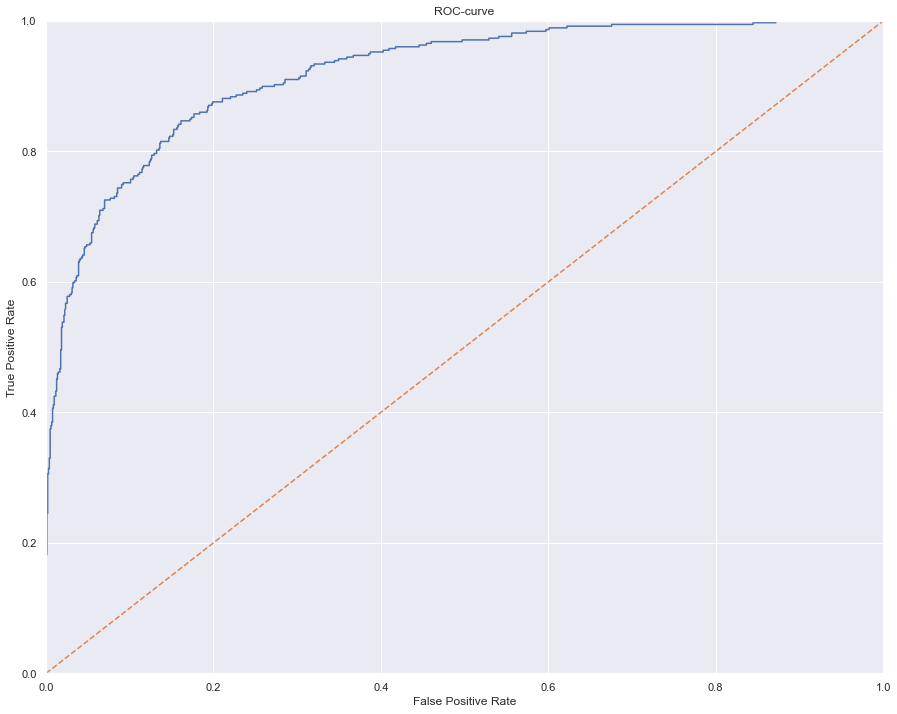

In [915]:
def make_roc_curve(target_test, prediction_test):
    fpr, tpr, thresholds = roc_curve(target_test, prediction_test)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-curve')
    plt.show()
    
make_roc_curve(lgbm.target_test, lgbm.model_test.predict_proba(lgbm.features_test)[:, 1])

### 4.2 Оценка важности признаков итоговой модели

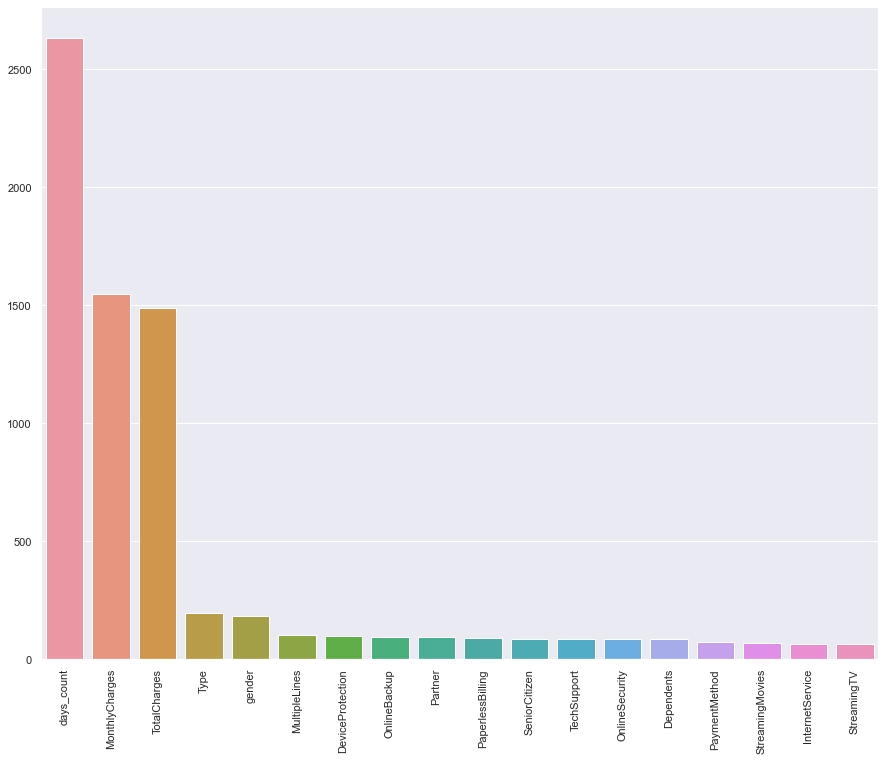

In [916]:
feature_importances = pd.DataFrame(data = {'feature': lgbm.features.columns, 'importance': lgbm.model_test.feature_importances_})


sns.set(rc={'figure.figsize':(15,12)}, font_scale = 1)
plt.xticks(rotation=90)
sns.barplot(x=feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)['feature'].values,
           y=feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)['importance'].values)
plt.show()

### Вывод по пункту 4

In [917]:
print(
f" \
Вывод по пункту 4: \
На этапе тестирования: \
Модель = {valid_table.values[idxmax][0]}, \
roc_auc_score = {test_table.values[0][2]}, \
accuracy = {test_table.values[0][3]} \
")

 Вывод по пункту 4: На этапе тестирования: Модель = lgbm, roc_auc_score = 0.92, accuracy = 0.87 


In [918]:
print(
f"\
Топ-5 важных параметров для модели: \
\n\n    \
{list(feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)['feature'].head(5))} \
")

Топ-5 важных параметров для модели: 

    ['days_count', 'MonthlyCharges', 'TotalCharges', 'Type', 'gender'] 


## 5. Вывод

### Выводы:

- Загрузили и объединили данные. Получили датасет: 7043 записей, 19 столбцов. Обработали пропуски по ряду столбцов.
- Преобразовали форматы столбцов.
- В столбце TotalCharges иногда формируются пустоты, что связано с тем, что пользователи не успели заплатить. Дата BeginDate совпадает с EndDate, MonthlyCharges != 0. Произвели замену нулями.
- создали 2 признака: (1) сколько дней человек пробыл клиентом компании, (**2 - ключевой признак**) ушел ли в итоге клиент.
- Замечен дисбаланс в классах целевого признака exited, при разделении данных использовали стратифицированный сплит

**Из графиков распределения численных параметров было видно:**

1. Значения столбца помесячной оплаты MonthlyCharges больше для ушедших клиентов. Возможно, это и было причиной их ухода. 
2. Значения столбца общей платы TotalCharges больше для текущих клиентов. Логично, что в долгосрочной перспективе профит от постоянных клиентов больше. 

**Ушедшие клиенты в основном характеризуются следующим образом:**
1. Тип оплаты Type = Month-to-Month, то есть помесячная оплата. Возможно, следует предлагать долгосрочные подписки.
2. Способ оплаты PaymentMethod = Electronic Check.
3. Клиенты без супруга (Partner = 0) и без иждивенцев (Dependents = 0).
4. бОльшее количество ушедших использует fiber optic, но при этом бОльшее количество ушедших не использует услуги OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport. Возможно, стоит усилить продвижение данных услуг.

**По результатам обучения, валидации и тестирования:**
- На этапе валидации: лучшая модель = lgbm, roc_auc_score = 0.89
- На этапе тестирования: Модель = lgbm, roc_auc_score = 0.92 
- Топ-5 важных параметров для модели: 'days_count', 'MonthlyCharges', 'TotalCharges', 'Type', 'gender', из них по графику важности выделяются три: 

1. 'days_count' - сколько дней человек пробыл клиентом компании
2. 'MonthlyCharges' - ежемесячные траты на услуги
3. 'TotalCharges' - всего потрачено денег на услуги

- По градуировке качества roc_auc_score, достигли лучшей группы качества на тестовой выборке ROC >= 0.88 (=0.92) 